In [1]:
from BcomMEG import *
import mne
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
epo_files = []
subjects = ['BCOM_18_2']
avoid_reading = True
for subject in subjects:
    for root, dirs, files in os.walk(dir):
            for file in files:
                if file.startswith(subject):
                    epo_name = file[10:-8]

                    if (avoid_reading == True) and (sum(c.isdigit() for c in epo_name) < 3): #segments where the subject is actually just reading rather than imagining have 2 digits
                        continue
            
                    file = os.path.join(dir, file)
                    epo_files.append(file)

In [6]:
dir = '/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/Data_Sample'
subjects = ['BCOM_18_2']
picks = None
avoid_reading = False

y = BcomMEG(subjects=subjects, dir=dir, picks=picks, avoid_reading=avoid_reading)

Reading /Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/Data_Sample/BCOM_18_2_ma_32-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/Data_Sample/BCOM_18_2_i_16-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/Data_Sample/BCOM_18_2_me_34-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/ciprianb

In [7]:
epo_1 = y.data['BCOM_18_2']['ma_32']

In [6]:
y.data

{'BCOM_18_2': {'ma_32': <EpochsFIF | 18 events (all good), -0.3 – 0.5 s (baseline off), ~8.5 MB, data loaded,
   '32': 18>,
  'i_16': <EpochsFIF | 12 events (all good), -0.3 – 0.5 s (baseline off), ~5.8 MB, data loaded,
   '16': 12>,
  'me_34': <EpochsFIF | 12 events (all good), -0.3 – 0.5 s (baseline off), ~5.8 MB, data loaded,
   '34': 12>,
  'si_56': <EpochsFIF | 6 events (all good), -0.3 – 0.5 s (baseline off), ~3.1 MB, data loaded,
   '56': 6>,
  're_44': <EpochsFIF | 8 events (all good), -0.3 – 0.5 s (baseline off), ~4.0 MB, data loaded,
   '44': 8>,
  'li_26': <EpochsFIF | 14 events (all good), -0.3 – 0.5 s (baseline off), ~6.7 MB, data loaded,
   '26': 14>,
  'ti_66': <EpochsFIF | 6 events (all good), -0.3 – 0.5 s (baseline off), ~3.1 MB, data loaded,
   '66': 6>,
  'ra_42': <EpochsFIF | 14 events (all good), -0.3 – 0.5 s (baseline off), ~6.7 MB, data loaded,
   '42': 14>,
  'ta_62': <EpochsFIF | 11 events (all good), -0.3 – 0.5 s (baseline off), ~5.4 MB, data loaded,
   '62': 

In [ ]:
range(len(epo_1))

In [8]:
frequencies = np.array(range(2, 100, 2))  # Frequency range from 2 to 40 Hz, in steps of 2
n_cycles = frequencies / 7 

powers = []
# Number of cycles, adjust as needed
power = mne.time_frequency.tfr_morlet(
epo_1[0], 
freqs=frequencies, 
n_cycles=n_cycles, 
use_fft=True, 
return_itc=False,  # Only power, not inter-trial coherence
decim=3,           # Decimate to reduce memory usage
n_jobs=10)          # Number of parallel jobs
powers.append(power)           

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished


In [12]:
frequencies = np.array(range(2, 100, 2))  # Frequency range from 2 to 40 Hz, in steps of 2
n_cycles = frequencies / 7   # Number of cycles, adjust as needed
power = mne.time_frequency.tfr_morlet(
    epo_1[0], 
    freqs=frequencies, 
    n_cycles=n_cycles, 
    use_fft=True, 
    return_itc=False,  # Only power, not inter-trial coherence
    decim=3,           # Decimate to reduce memory usage
    n_jobs=1           # Number of parallel jobs
)

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


Applying baseline correction (mode: logratio)


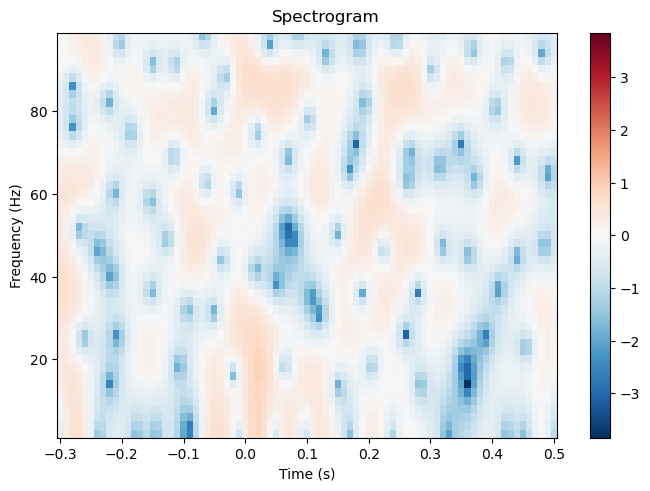

[<Figure size 640x480 with 2 Axes>]

In [13]:
power.plot(
    picks='MEG 001',  # Replace with specific channel name or type, e.g., 'MEG 1332'
    baseline=(None, 0),  # Baseline correction (optional)
    mode='logratio',       # Baseline normalization method
    title="Spectrogram"
)

In [3]:
frequencies = np.array(range(2, 100, 2))  # Frequency range from 2 to 40 Hz, in steps of 2
divisor = 7
baseline=(None, 0)
x = y.get_spectrogram(frequencies=frequencies, cycle_divisor=divisor, baseline=baseline, mode='logratio')

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 116 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    2.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 172 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.1s finished


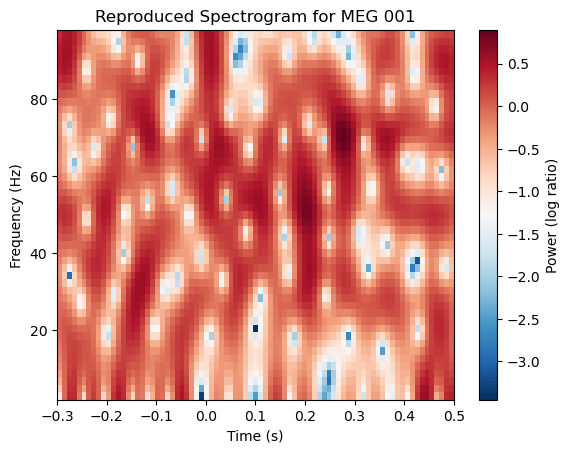

In [16]:
# Manually reproduce the plot for 'MEG 001'
channel_idx = x.data['BCOM_18_2']['a_12'][0].ch_names.index('MEG 001')  # Find the channel index

corrected_data = x.data['BCOM_18_2']['a_12'][0].data[channel_idx, :, :]

# Plot corrected data
import matplotlib.pyplot as plt
plt.imshow(
    corrected_data,
    aspect='auto',
    origin='lower',
    extent=[x.data['BCOM_18_2']['a_12'][0].times[0], x.data['BCOM_18_2']['a_12'][0].times[-1], x.data['BCOM_18_2']['a_12'][0].freqs[0], x.data['BCOM_18_2']['a_12'][0].freqs[-1]],
    cmap='RdBu_r'
)
plt.colorbar(label='Power (log ratio)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Reproduced Spectrogram for MEG 001')
plt.show()

In [ ]:
tfr_data.shape #magnetometers by frequencies by time_bins
#So what if we take the represntation of all the magnetometers?
# How would that work then? I guess each of them would have a 247 dimensional representation? Or you just average over them?
# Idk if averaging really makes sense here but it would reduce it down to the 1 power
# Or we just use a 3D convolution? Like you stack them all so that instead
# of 3 color channels, its as though there were 247 of them?
# Or do we try to stitch them all together?
